In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import pandas as pd
import networkx as nx
import numpy as np
import sys
import seaborn as sns

In [22]:
results_folder = 'mmvec_major_taxa_scrambled_2'
results_base_name = 'latent_dim_3_input_prior_100.00_output_prior_100.00_beta1_0.90_beta2_0.95'

# Input data

In [23]:
table = pd.read_table(results_folder + '/' + results_base_name + '_ranks.txt', index_col=0)
table.head()

,Propionibacteriaceae,Staphylococcus caprae or capitis,Staphylococcus epidermidis,Staphylococcus hominis,Other Staphylococci,Polyomavirus HPyV6,Polyomavirus HPyV7,Merkel Cell Polyomavirus,Malasseziaceae,Corynebacteriaceae,Micrococcaceae,Other families
featureid,,,,,,,,,,,,
X940001,0.180018,0.130804,-0.038078,0.240374,0.194570,0.110777,0.011359,0.177041,0.052316,-0.036360,0.073138,0.072904
X940002,0.170904,0.067685,-0.055999,0.017175,-0.013072,0.110346,-0.176790,-0.254278,-0.102524,-0.072218,-0.068605,-0.010480
X940005,0.053946,0.037144,-0.094905,0.051030,-0.020518,0.076090,-0.051974,-0.363057,-0.164155,-0.139262,-0.047967,-0.006587
X940007,0.877777,0.571962,0.413489,0.477071,0.440752,0.640828,0.027406,0.089059,0.325998,0.389187,0.366404,0.425524
X940010,0.577252,0.988029,0.250292,0.541471,0.585589,1.151453,0.599814,0.080855,0.356335,0.356728,0.083235,0.702426


Read microbiome metadata: Not needed as the taxon names are the column headers

Read metabolite metadata: Not needed as we are working with molecular families

# Check stats

There seams to be a local minimum of the model fit where all metabolites have (nearly) identical log conditional probabilities for every microbe.

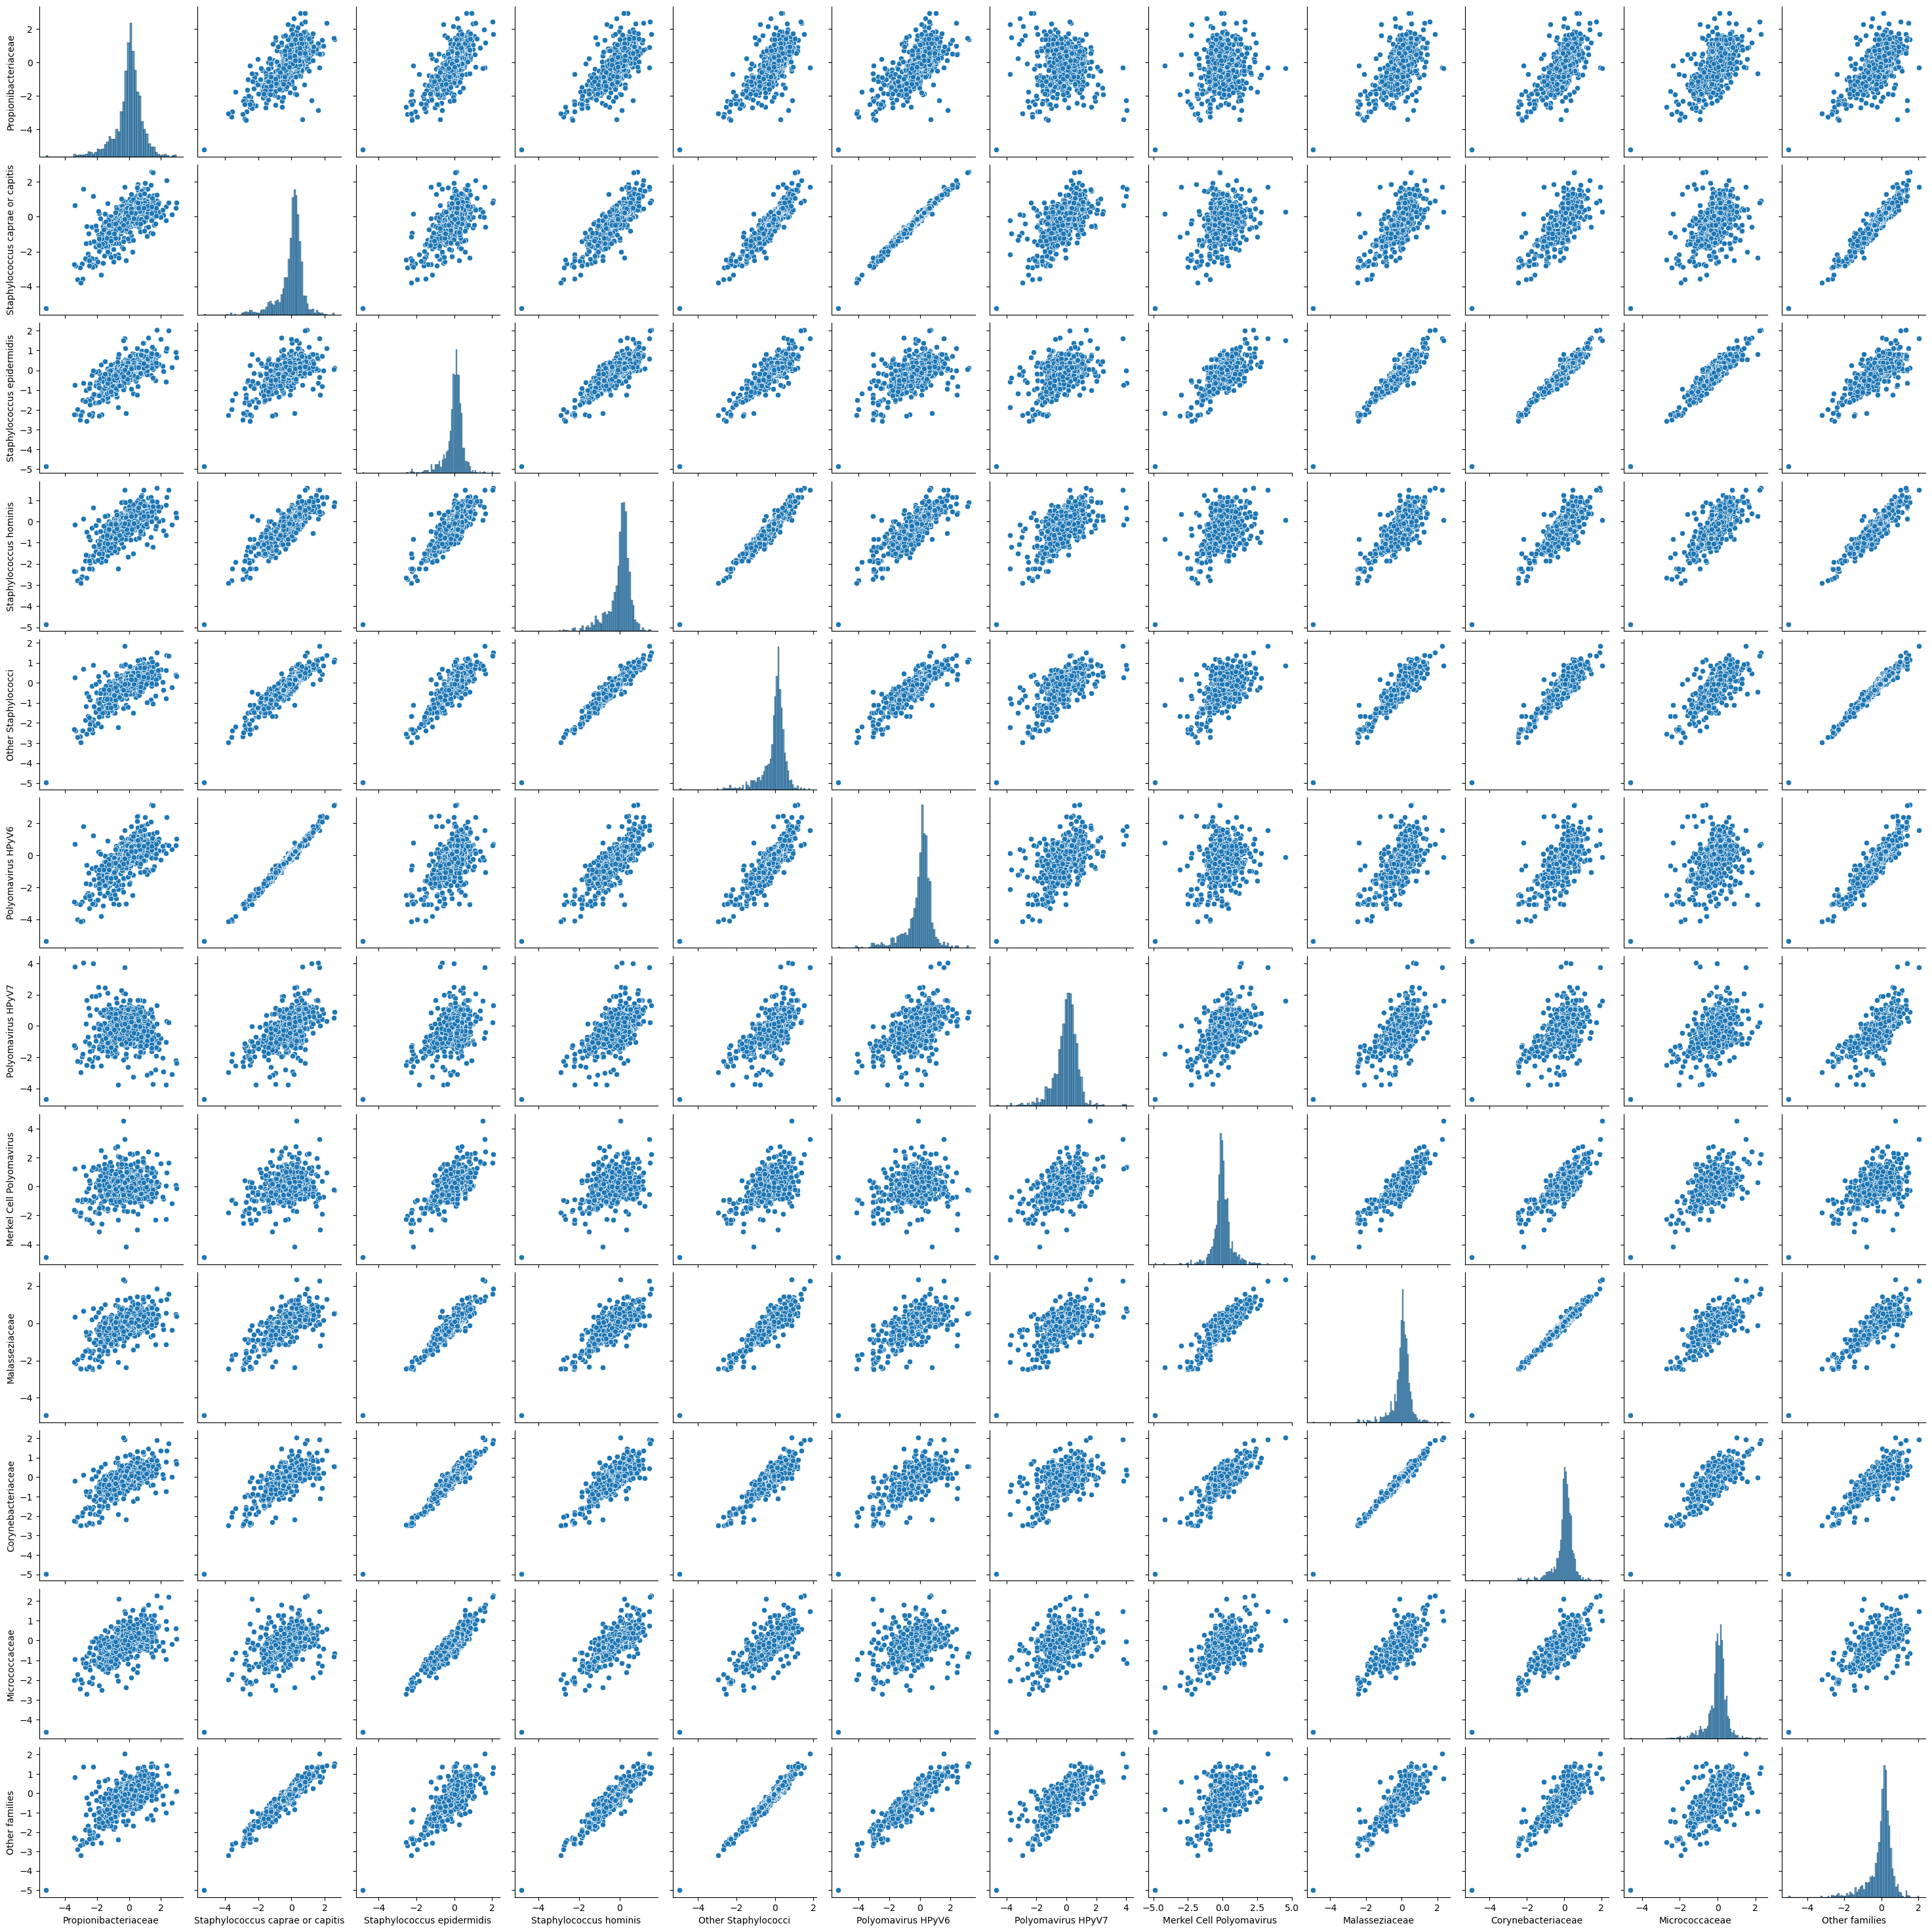

In [24]:
sns.pairplot(table)

The local density of this plot could be calculated with np.histogram:
https://stackoverflow.com/questions/33967513/creating-density-estimate-in-numpy
https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work

Because the data is m-dimensional (m = # microbes), we need np.histogramdd:
https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html

Alternatively, one could use an m-dimensional (m = # microbes) Hotelling ellipsoid at 95% cutoff:
https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

# Transform data

Transform into wide format and rank the results:

In [25]:
longform_pairwise = table.unstack().to_frame('interactionLogCondProb')
longform_pairwise['interactionLogCondProb_abs'] = abs(longform_pairwise['interactionLogCondProb'])
longform_pairwise['interactionLogCondProb_sign'] = np.where(longform_pairwise['interactionLogCondProb'] > 0, 
                                                                 'positive', 'negative')
longform_pairwise.sort_values('interactionLogCondProb_abs', ascending=False, inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.head()

,index,level_0,featureid,interactionLogCondProb,interactionLogCondProb_abs,interactionLogCondProb_sign
0,0,Polyomavirus HPyV6,X941392,-5.339489,5.339489,negative
1,1,Staphylococcus caprae or capitis,X941392,-5.239596,5.239596,negative
2,2,Propionibacteriaceae,X941392,-5.209935,5.209935,negative
3,3,Other families,X941392,-5.004728,5.004728,negative
4,4,Other Staphylococci,X941392,-4.965595,4.965595,negative


# Graph

In [26]:
G = nx.Graph()
G = nx.from_pandas_edgelist(longform_pairwise, 'level_0', 'featureid',
                            edge_attr=['index', 'interactionLogCondProb', 'interactionLogCondProb_abs', 'interactionLogCondProb_sign'])
nx.info(G)

/tmp/ipykernel_1101/2291082867.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 1237 nodes and 14700 edges'

Add node_type as node attribute

In [27]:
microbe_metadata = pd.DataFrame(index = table.columns.values)
microbe_metadata['node_type'] = 'microbe' 
microbe_metadata.head()

,node_type
Propionibacteriaceae,microbe
Staphylococcus caprae or capitis,microbe
Staphylococcus epidermidis,microbe
Staphylococcus hominis,microbe
Other Staphylococci,microbe


In [28]:
metabolite_metadata = pd.DataFrame(index = table.index.values)
metabolite_metadata['node_type'] = 'metabolite' 
metabolite_metadata.head()

,node_type
X940001,metabolite
X940002,metabolite
X940005,metabolite
X940007,metabolite
X940010,metabolite


In [29]:
nx.set_node_attributes(G, microbe_metadata.T.to_dict())
nx.set_node_attributes(G, metabolite_metadata.T.to_dict())

In [30]:
nx.write_graphml(G, results_folder + '/' + results_base_name + '_graph.graphml')